# Final Year Project
## Project # 3
### Group 3

## Imports

Libraries used in this notebook.

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage.transform import rotate
from skimage import morphology
from skimage import measure
import math

## Constants

Constants to access data on the directory structure of this repository.

In [14]:
IMG_PATH = './data/example_image/'
SEG_PATH = './data/example_segmentation/'
FEAT_PATH = './features/'

TRUTH = './data/ISIC-2017_Training_Part3_GroundTruth.csv'
FEATURES = '/features/features.csv'

## Functions

Functions created for this notebook.

In [140]:
"""FUNCTIONS FOR MASKED IMAGES"""

def get_boundaries(image):
    """Function to locate the boundaries of the lesion over the whole image.
    Takes a segmentation mask image as argument and returns the upper, lower, left and right boundaries."""

    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def get_center(image): # NOT NEEDED ANYMORE ?

    up, dw, lt, rt = get_boundaries(image)
    center = ((up+dw)/2, (lt+rt)/2)
    return center
    
def zoom(image):
    """Function to zoom-in (crop) the lesion from blank space. Takes a segmentation mask image as input,
    and returns the rectangle where the lesion is found."""

    up, dw, lt, rt = get_boundaries(image)
    rectangle = image[up:dw+1, lt:rt+1]
    return rectangle

def cuts(image):
    """Function to perform a double cut (vertical and horizontal) of the lesion. Takes a segmentation mask image as input,
    and returns the vertical and horizontal cuts (2 for each dimension). It handles uneven shapes."""

    center_h = image.shape[0] // 2 # The image shape contains a tuple with height and width (in pixels)
    if image.shape[0] % 2 == 0: # If the height is an even number of pixels, the cut returns 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h:,:]
    else: # If the height is an uneven number of pixels, the cut has to "share" the center, to return 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h+1:,:]
        
    center_w = image.shape[1] // 2    
    if image.shape[1] % 2 == 0:
        leftside = image[:,:center_w]
        rightside = image[:,center_w:]
    else:
        leftside = image[:,:center_w]
        rightside = image[:,center_w+1:]
 
    return upside, downside, leftside, rightside


def test_symmetry(image, rot_deg=30):
    """Function to test the symmetry of an image. Takes a segmentation mask image and the rotation degree interval and
    returns a symmetry score between zero (non-symmetric) to one (completely symmetric)."""

    assert (rot_deg <= 90) and (rot_deg >= 0), "Rotation degree should be positive and at most 90 deg"
    optimal = 0
    
    for deg in range(0,91, rot_deg):
        rot_image = skimage.transform.rotate(image, deg)
        z = zoom(rot_image)
        
        upside, downside, leftside, rightside = cuts(z)

        up_dw = np.sum(np.bitwise_and(upside.astype(int), np.flipud(downside).astype(int))) /\
        np.sum(np.bitwise_or(upside.astype(int), np.flipud(downside).astype(int)))

        lt_rt = np.sum(np.bitwise_and(leftside.astype(int), np.fliplr(rightside).astype(int))) /\
        np.sum(np.bitwise_or(leftside.astype(int), np.fliplr(rightside).astype(int)))
    
        symmetry = (up_dw+lt_rt)/2
        
        if symmetry > optimal: optimal = symmetry

    return symmetry
    
def rgb2gray(rgb):
    """Function to convert a RGB image to grayscale."""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def crop(image, mask):
    img = image.copy()
    img[mask==0] = 0
    return img

def color_std(image):
    try:
        R = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,0]
        G = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,1]
        B = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,2]
        color_std = (np.std(R) + np.std(G) + np.std(B)) /3
    except:
        color_std = 'NA'
    return color_std

def check_border(image, border=0.01, tolerance=0.2, warning=True):
    """Function to check if the lesion might be exceeding the image. Take the following arguments:
    - image: segmentation mask image to check.
    - border: the percentage of pixels to consider as a border. 10% by default.
    - tolerance: the percentage of tolerance for a lesion to be at the border of the image. 20% by default.
    - warning: boolean to indicate if a textual warning should be issue when checking the border. True by default."""
    h = int(image.shape[0] * border)
    w = int(image.shape[1] * border)
    up = (np.sum(image[h,:]) / image.shape[1]) > tolerance
    dw = (np.sum(image[-h,:]) / image.shape[1]) > tolerance
    lt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    rt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    if warning:
        if up or dw or lt or rt: return "This lesion might be overflowing the image"
        else: return "This lesion does not seem to be overflowing the image"
    else:
        return up or dw or lt or rt
    
"""
#def laydown(image): # I THINK WE MAY NOT NEED THIS
#    z = zoom(image)
#    u, d, l, r = get_boundaries(z)
#    if (d-u) >= (r-l):
#        return skimage.transform.rotate(image, 90) 
#    else: return image
        
def reverse(image):
    new = image.copy()
    new[np.where(image == 1)], new[np.where(image == 0)] = 0, 1
    return new
"""
def measure_area_perimeter(mask, option=1):
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    if option == 1:
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded

        # Now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)
    else:
        perimeter = measure.perimeter(mask)
        

    return area, perimeter

  

## Exploratory Data Analysis

(NOTE) Here we could show how we visualize a couple of images and masks to get familiar with the images and its attributes.

## Dataset Creation

(NOTE) We load and access the metadata included in our source data.

In [7]:
df = pd.read_csv(TRUTH, index_col='image_id')
df = df.astype(int) # Transform to int
df.head()

,melanoma,seborrheic_keratosis
image_id,,
ISIC_0000000,0,0
ISIC_0000001,0,0
ISIC_0000002,1,0
ISIC_0000003,0,0
ISIC_0000004,1,0


In [8]:
df['non-cancer'] = 1- df.sum(axis=1) # Define a 'non-cancer' label

## Feature Extraction

(NOTE) We proceed to extract features of interest for our predictive model

#### Asymmetry

To test for asymmetry we run a function to calculate a score based on how similar an image is when cut horizontally and vertically. We assign a score between 0 (non asymmetric) and 1 (totally asymmetric) for both cuts, and we take the average to convey a unique value.

In [38]:
WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

REWRITE = input("Do you wish to overwrite the /features/symmetry.csv file?: (Yes/No) ")
print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    symmetry = {}
    i = 1
    for ix, row in df[:10].iterrows():
        file_path = SEG_PATH + str(ix) + "_segmentation.png"
        image = plt.imread(file_path)
        
        ptg = round((i / 10) * 100,2)
        print(f'\rCalculating symmetry: {ptg}%', end='\r')
        symmetry[ix] = test_symmetry(image)
        i += 1
else: print("OPERATION CANCELLED")
    
if REWRITE.lower().startswith("y"):
    with open(FEAT_PATH + 'symmetry.csv', 'w') as outfile:
        outfile.write('image_id'+','+'symmetry'+'\n')
        for k, v in symmetry.items():
            line = k +','+str(v)
            outfile.write(line+'\n')

This operation may take several minutes. Do you wish to continue: (Yes/No) y
Do you wish to overwrite the /features/symmetry.csv file?: (Yes/No) no

----- PLEASE BE PATIENT -----



#### Border

In [143]:
WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

REWRITE = input("Do you wish to overwrite the /features/compactness.csv file?: (Yes/No) ")
print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    compactness = {}
    i = 1
    for ix, row in df.iterrows():
        file_path = SEG_PATH + str(ix) + "_segmentation.png"
        image = plt.imread(file_path)
        
        ptg = round(i / len(df.index)*100,2)
        print(f'\rCalculating compactness: {ptg}%', end='\r')
        area, per = measure_area_perimeter(image, option=2)
        compactness[ix] = (4* math.pi * area) / (per**2)
        i += 1
else: print("OPERATION CANCELLED")
    
if REWRITE.lower().startswith("y"):
    with open(FEAT_PATH + 'compactness.csv', 'w') as outfile:
        outfile.write('image_id'+','+'compactness'+'\n')
        for k, v in compactness.items():
            line = k +','+str(v)
            outfile.write(line+'\n')

This operation may take several minutes. Do you wish to continue: (Yes/No) y
Do you wish to overwrite the /features/compactness.csv file?: (Yes/No) y

----- PLEASE BE PATIENT -----



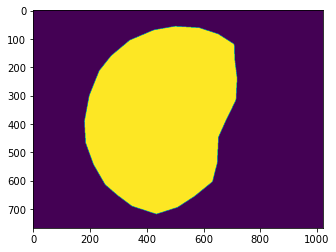

In [98]:
plt.imshow(test)

In [142]:
rect = np.ones([4,4])
print(measure_area_perimeter(test, option=2))
lt = np.where(rect == 1)
#print(list(lt[0])+list(lt[1]))
x= len(set(list(lt[0]) + list(lt[1])))
x

(269484.0, 2014.4103884177655)


4

In [109]:

len(set(lt)) + len(set(lt2))

1199

#### Color

### Model

#### Creation

#### Data splitting

#### Feature scalling

#### Model fitting

#### Model prediction

#### Model score